# Multiclass Text Classification with 
# Logistic Regression Implemented with PyTorch and CE Loss

First, we will do some initialization.

In [ ]:
import random 
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cpu
random seed: 1234


We will be using the AG's News Topic Classification Dataset.
It is stored in two CSV files: `train.csv` and `test.csv`, as well as a `classes.txt` that stores the labels of the classes to predict.

First, we will load the training dataset using [pandas](https://pandas.pydata.org/) and take a quick look at how the data.

In [ ]:
train_df = pd.read_csv('./train.csv', header=None) # leemos el archivo csv
train_df.columns = ['class index', 'title', 'description'] # le asignamos nombres a las columnas
train_df # mostramos el dataframe

,class index,title,description
0,Class Index,Title,Description
1,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
2,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
3,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
4,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
...,...,...,...
119996,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119997,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119998,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119999,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


The dataset consists of 120,000 examples, each consisting of a class index, a title, and a description.
The class labels are distributed in a separated file. We will add the labels to the dataset so that we can interpret the data more easily. Note that the label indexes are one-based, so we need to subtract one to retrieve them from the list.

In [ ]:
labels = open('./classes.txt').read().splitlines() # leemos las etiquetas de las clases
train_df = train_df.drop(0).reset_index(drop=True)  # eliminamos la primera fila 
train_df['class index'] = train_df['class index'].astype(int) # convertimos la columna 'class index' a entero 
classes = train_df['class index'].map(lambda i: labels[i-1]) # mapeamos los indices de las clases a las etiquetas
train_df.insert(1, 'class', classes) # insertamos la columna 'class' en la posición 1
train_df # mostramos el dataframe

,class index,class,title,description
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


Let's inspect how balanced our examples are by using a bar plot.

/var/folders/7b/g3f6kzfd1b99b918vd8tvd100000gn/T/ipykernel_25959/1245903889.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_df['class']).plot.bar()


<Axes: xlabel='class'>

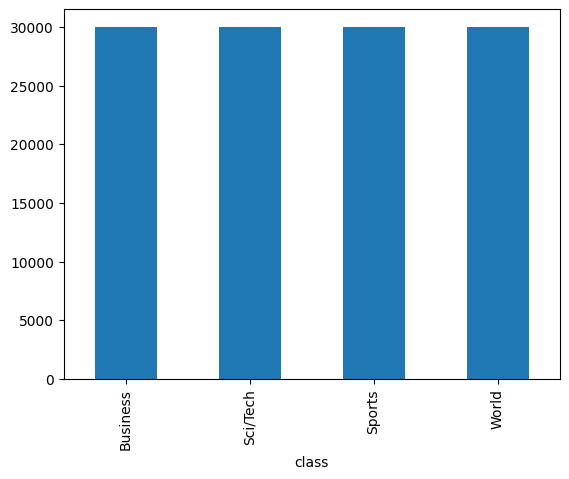

In [ ]:
pd.value_counts(train_df['class']).plot.bar() # graficamos la distribución de las clases

The classes are evenly distributed. That's great!

However, the text contains some spurious backslashes in some parts of the text.
They are meant to represent newlines in the original text.
An example can be seen below, between the words "dwindling" and "band".

In [ ]:
print(train_df.loc[0, 'description']) # mostramos la descripción de la primera fila

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


We will replace the backslashes with spaces on the whole column using pandas replace method.

In [ ]:
title = train_df['title'].str.lower() # convertimos el título a minúsculas 
descr = train_df['description'].str.lower() # convertimos la descripción a minúsculas 
text = title + " " + descr # concatenamos el título y la descripción
train_df['text'] = text.str.replace('\\', ' ', regex=False) # reemplazamos los caracteres '\' por ' '
train_df # mostramos el dataframe

,class index,class,title,description,text
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new..."
...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...


Now we will proceed to tokenize the title and description columns using NLTK's word_tokenize().
We will add a new column to our dataframe with the list of tokens.

In [ ]:
import nltk # importamos la librería nltk
nltk.download('punkt_tab') # descargamos el tokenizador 'punkt', que tiene un mejor rendimiento que el tokenizador 'punkt'

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hibrantapia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize # importamos la función word_tokenize de la librería nltk

train_df['tokens'] = train_df['text'].progress_map(word_tokenize) # tokenizamos el texto y lo guardamos en la columna 'tokens'
train_df # mostramos el dataframe

  0%|          | 0/120000 [00:00<?, ?it/s]

,class index,class,title,description,text,tokens
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...,"[wall, st., bears, claw, back, into, the, blac..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...,"[carlyle, looks, toward, commercial, aerospace..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...,"[oil, and, economy, cloud, stocks, ', outlook,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...,"[iraq, halts, oil, exports, from, main, southe..."
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new...","[oil, prices, soar, to, all-time, record, ,, p..."
...,...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...,"[pakistan, 's, musharraf, says, wo, n't, quit,..."
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...,"[renteria, signing, a, top-shelf, deal, red, s..."
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...,"[saban, not, going, to, dolphins, yet, the, mi..."
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...,"[today, 's, nfl, games, pittsburgh, at, ny, gi..."


Now we will create a vocabulary from the training data. We will only keep the terms that repeat beyond some threshold established below.

In [ ]:
threshold = 10 # umbral de frecuencia de las palabras
tokens = train_df['tokens'].explode().value_counts() # contamos la frecuencia de las palabras 
tokens = tokens[tokens > threshold] # seleccionamos las palabras que superan el umbral de frecuencia
id_to_token = ['[UNK]'] + tokens.index.tolist() # creamos una lista con las palabras que superan el umbral de frecuencia
token_to_id = {w:i for i,w in enumerate(id_to_token)} # creamos un diccionario con las palabras que superan el umbral de frecuencia 
vocabulary_size = len(id_to_token) # obtenemos el tamaño del vocabulario
print(f'vocabulary size: {vocabulary_size:,}') # mostramos el tamaño del vocabulario

vocabulary size: 19,668


In [ ]:
from collections import defaultdict # importamos la clase defaultdict de la librería collections

def make_feature_vector(tokens, unk_id=0): # esta es la función que convierte los tokens en un vector de características
    vector = defaultdict(int) # inicializamos un diccionario con valores enteros
    for t in tokens: # iteramos sobre los tokens 
        i = token_to_id.get(t, unk_id) # obtenemos el índice de la palabra en el diccionario
        vector[i] += 1 # incrementamos el valor del índice en el diccionario
    return vector # retornamos el diccionario

train_df['features'] = train_df['tokens'].progress_map(make_feature_vector) # convertimos los tokens en un vector de características
train_df # mostramos el dataframe

  0%|          | 0/120000 [00:00<?, ?it/s]

,class index,class,title,description,text,tokens,features
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...,"[wall, st., bears, claw, back, into, the, blac...","{427: 2, 566: 1, 1609: 1, 15347: 1, 120: 1, 73..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...,"[carlyle, looks, toward, commercial, aerospace...","{16371: 2, 1077: 1, 854: 1, 1287: 1, 4243: 1, ..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...,"[oil, and, economy, cloud, stocks, ', outlook,...","{66: 1, 9: 2, 351: 2, 4575: 1, 158: 1, 116: 1,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...,"[iraq, halts, oil, exports, from, main, southe...","{77: 2, 7404: 1, 66: 3, 1785: 1, 32: 2, 900: 2..."
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new...","[oil, prices, soar, to, all-time, record, ,, p...","{66: 2, 99: 2, 4376: 1, 4: 2, 3590: 1, 149: 1,..."
...,...,...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...,"[pakistan, 's, musharraf, says, wo, n't, quit,...","{383: 1, 23: 1, 1625: 2, 91: 1, 1804: 1, 285: ..."
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...,"[renteria, signing, a, top-shelf, deal, red, s...","{8468: 2, 2634: 1, 5: 4, 0: 3, 127: 1, 203: 3,..."
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...,"[saban, not, going, to, dolphins, yet, the, mi...","{7747: 2, 68: 1, 660: 1, 4: 2, 1440: 2, 704: 1..."
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...,"[today, 's, nfl, games, pittsburgh, at, ny, gi...","{106: 1, 23: 1, 728: 1, 225: 1, 1588: 1, 22: 1..."


In [ ]:
def make_dense(feats): # esta función convierte el vector de características en un vector denso
    x = np.zeros(vocabulary_size) # inicializamos un vector de ceros
    for k,v in feats.items(): # iteramos sobre los elementos del vector de características
        x[k] = v # asignamos el valor del elemento al vector denso
    return x # retornamos el vector denso 

X_train = np.stack(train_df['features'].progress_map(make_dense)) # convertimos los vectores de características en una matriz
y_train = train_df['class index'].to_numpy() - 1 # convertimos las etiquetas a un arreglo de numpy
 
X_train = torch.tensor(X_train, dtype=torch.float32) # convertimos la matriz de características a un tensor de torch
y_train = torch.tensor(y_train) # convertimos el arreglo de etiquetas a un tensor de torch

  0%|          | 0/120000 [00:00<?, ?it/s]

In [ ]:
from torch import nn # importamos el módulo nn de torch
from torch import optim # importamos el módulo optim de torch

# hyperparameters
lr = 1.0 # learning rate
n_epochs = 5 # number of epochs
n_examples = X_train.shape[0] # number of examples
n_feats = X_train.shape[1] # number of features
n_classes = len(labels) # number of classes

# initialize the model, loss function, optimizer, and data-loader
model = nn.Linear(n_feats, n_classes).to(device) # initialize the model
loss_func = nn.CrossEntropyLoss() # initialize the loss function
optimizer = optim.SGD(model.parameters(), lr=lr) # initialize the optimizer

# train the model
indices = np.arange(n_examples) # create an array of indices
for epoch in range(n_epochs): # iterate over the epochs
    np.random.shuffle(indices) # shuffle the indices
    for i in tqdm(indices, desc=f'epoch {epoch+1}'): # iterate over the examples
        # clear gradients
        model.zero_grad() # clear gradients
        # send datum to right device
        x = X_train[i].unsqueeze(0).to(device) # send the feature vector to the right device
        y_true = y_train[i].unsqueeze(0).to(device) # send the label to the right device
        # predict label scores
        y_pred = model(x) # predict the label scores
        # compute loss
        loss = loss_func(y_pred, y_true) # 
        # backpropagate
        loss.backward() # backpropagate the loss
        # optimize model parameters
        optimizer.step() # optimize the model parameters

epoch 1:   0%|          | 0/120000 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/120000 [00:00<?, ?it/s]

epoch 3:   0%|          | 0/120000 [00:00<?, ?it/s]

epoch 4:   0%|          | 0/120000 [00:00<?, ?it/s]

epoch 5:   0%|          | 0/120000 [00:00<?, ?it/s]

Next, we evaluate on the test dataset

In [ ]:
# repeat all preprocessing done above, this time on the test set
test_df = pd.read_csv('./test.csv', header=None) # leemos el archivo csv
test_df.columns = ['class index', 'title', 'description'] # le asignamos nombres a las columnas
test_df['text'] = test_df['title'].str.lower() + " " + test_df['description'].str.lower() # concatenamos el título y la descripción
test_df['text'] = test_df['text'].str.replace('\\', ' ', regex=False) # reemplazamos los caracteres '\' por ' '
test_df['tokens'] = test_df['text'].progress_map(word_tokenize) # tokenizamos el texto y lo guardamos en la columna 'tokens'
test_df['features'] = test_df['tokens'].progress_map(make_feature_vector) # convertimos los tokens en un vector de características

  0%|          | 0/7601 [00:00<?, ?it/s]

  0%|          | 0/7601 [00:00<?, ?it/s]

,class index,title,description,text,tokens,features
0,Class Index,Title,Description,title description,"[title, description]","{394: 1, 3701: 1}"
1,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,fears for t n pension after talks unions repre...,"[fears, for, t, n, pension, after, talks, unio...","{862: 1, 11: 1, 151: 1, 5349: 1, 1471: 1, 38: ..."
2,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",the race is on: second private team sets launc...,"[the, race, is, on, :, second, private, team, ...","{1: 3, 493: 1, 24: 1, 10: 1, 28: 1, 133: 2, 92..."
3,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,ky. company wins grant to study peptides (ap) ...,"[ky., company, wins, grant, to, study, peptide...","{11738: 1, 60: 2, 407: 1, 4362: 2, 4: 2, 514: ..."
4,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,prediction unit helps forecast wildfires (ap) ...,"[prediction, unit, helps, forecast, wildfires,...","{9154: 1, 612: 1, 2049: 1, 705: 1, 0: 4, 14: 1..."
...,...,...,...,...,...,...
7596,1,Around the world,Ukrainian presidential candidate Viktor Yushch...,around the world ukrainian presidential candid...,"[around, the, world, ukrainian, presidential, ...","{437: 1, 1: 2, 58: 1, 4477: 1, 389: 1, 1398: 1..."
7597,2,Void is filled with Clement,With the supply of attractive pitching options...,void is filled with clement with the supply of...,"[void, is, filled, with, clement, with, the, s...","{9010: 1, 24: 1, 4890: 1, 19: 3, 9831: 2, 1: 5..."
7598,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,martinez leaves bitter like roger clemens did ...,"[martinez, leaves, bitter, like, roger, clemen...","{2131: 2, 1790: 1, 2951: 2, 317: 1, 1698: 1, 2..."
7599,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,5 of arthritis patients in singapore take bext...,"[5, of, arthritis, patients, in, singapore, ta...","{627: 1, 6: 1, 2701: 1, 2439: 1, 7: 2, 1019: 2..."


In [ ]:
test_df = test_df.drop(index=0).reset_index(drop=True) # eliminamos la primera fila
test_df # mostramos el dataframe

,class index,title,description,text,tokens,features
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,fears for t n pension after talks unions repre...,"[fears, for, t, n, pension, after, talks, unio...","{862: 1, 11: 1, 151: 1, 5349: 1, 1471: 1, 38: ..."
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",the race is on: second private team sets launc...,"[the, race, is, on, :, second, private, team, ...","{1: 3, 493: 1, 24: 1, 10: 1, 28: 1, 133: 2, 92..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,ky. company wins grant to study peptides (ap) ...,"[ky., company, wins, grant, to, study, peptide...","{11738: 1, 60: 2, 407: 1, 4362: 2, 4: 2, 514: ..."
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...,prediction unit helps forecast wildfires (ap) ...,"[prediction, unit, helps, forecast, wildfires,...","{9154: 1, 612: 1, 2049: 1, 705: 1, 0: 4, 14: 1..."
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...,calif. aims to limit farm-related smog (ap) ap...,"[calif., aims, to, limit, farm-related, smog, ...","{1076: 1, 1713: 1, 4: 2, 3282: 1, 0: 4, 13226:..."
...,...,...,...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...,around the world ukrainian presidential candid...,"[around, the, world, ukrainian, presidential, ...","{437: 1, 1: 2, 58: 1, 4477: 1, 389: 1, 1398: 1..."
7596,2,Void is filled with Clement,With the supply of attractive pitching options...,void is filled with clement with the supply of...,"[void, is, filled, with, clement, with, the, s...","{9010: 1, 24: 1, 4890: 1, 19: 3, 9831: 2, 1: 5..."
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...,martinez leaves bitter like roger clemens did ...,"[martinez, leaves, bitter, like, roger, clemen...","{2131: 2, 1790: 1, 2951: 2, 317: 1, 1698: 1, 2..."
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...,5 of arthritis patients in singapore take bext...,"[5, of, arthritis, patients, in, singapore, ta...","{627: 1, 6: 1, 2701: 1, 2439: 1, 7: 2, 1019: 2..."


In [ ]:
test_df['class index'] = pd.to_numeric(test_df['class index'], errors='coerce') # convertimos la columna 'class index' a numérica


In [ ]:
X_test = np.stack(test_df['features'].progress_map(make_dense)) # convertimos los vectores de características en una matriz
y_test = test_df['class index'].to_numpy() - 1 # convertimos las etiquetas a un arreglo de numpy
X_test = torch.tensor(X_test, dtype=torch.float32) # convertimos la matriz de características a un tensor de torch
y_test = torch.tensor(y_test) # convertimos el arreglo de etiquetas a un tensor de torch

  0%|          | 0/7600 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report # importamos la función classification_report de la librería sklearn

# set model to evaluation mode
model.eval()

# don't store gradients
with torch.no_grad(): # no almacenar gradientes
    X_test = X_test.to(device) # enviar la matriz de características al dispositivo correcto
    y_pred = torch.argmax(model(X_test), dim=1) # predecir las etiquetas
    y_pred = y_pred.cpu().numpy() # convertir las etiquetas a un arreglo de numpy
    print(classification_report(y_test, y_pred, target_names=labels)) # mostrar el reporte de clasificación

              precision    recall  f1-score   support

       World       0.95      0.82      0.88      1900
      Sports       0.93      0.98      0.95      1900
    Business       0.85      0.86      0.85      1900
    Sci/Tech       0.82      0.89      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.88      7600
weighted avg       0.89      0.89      0.88      7600

